In [96]:
import psycopg2

import ujson
import copy
import numpy as np
import scipy.stats
import sys

%pylab inline

Populating the interactive namespace from numpy and matplotlib
time: 11.5 ms


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Testing auto adding time output to all cells
'''
#To install...
wget https://raw.githubusercontent.com/cpcloud/ipython-autotime/master/autotime.py
#Make available via
jupyter nbextension install /Users/patrickmulrooney/class/notebooks/pjmulroo/DSECapstone/autotime.py
'''
 
%load_ext autotime

In [3]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')


time: 44.8 ms


In [4]:
# Read config from local file
GMAP_API_KEY = None

sys.path.append('/Users/patrickmulrooney/Desktop/')
import capstone_config

_file, _ = capstone_config.getkeys()
print _file

/Users/patrickmulrooney/Downloads/endomondoHR/endoHRParsed_no_outliers.json
time: 4.36 ms


In [5]:
#time: 12min 44s
# Full dataset
#_file = "/Users/patrickmulrooney/Downloads/endomondoHR/endoHRParsed.json"
# Partial dataset
#_file = "/Users/patrickmulrooney/Downloads/endomondoHR/endoHRParsed_10k.json"

endoHR = []

with open(_file, 'r') as f:
    endoHR += ujson.load(f)

time: 46min 32s


In [6]:
for i in log_progress(endoHR, every=5):
    if i['sport'] == "bike (transport)":
        i['sport'] = "bike_transport"
        continue
    i['sport'] = i['sport'].replace(" ", "_")
    i['sport'] = i['sport'].replace("-", "_")

time: 1min 41s


In [24]:
dbname = 'endomondo'
conn = psycopg2.connect("dbname=endomondo user=patrickmulrooney")

# Open a cursor to perform database operations
cur = conn.cursor()

# # Make the changes to the database persistent
# conn.commit()

# # Close communication with the database
# cur.close()
# conn.close()

time: 36.2 ms


In [ ]:
# # https://docs.influxdata.com/influxdb/v1.1/concepts/key_concepts/#database
# for _endoHR in log_progress(endoHR, every=1):

#     _dict = {}
#     _dict["table"] = _endoHR['sport']
#     #_dict["gender"] = _endoHR['gender']
#     _dict["workoutId"] = _endoHR['id']
#     #_dict["userId"] = _endoHR['userId']


#     #_tags["sport"] = _endoHR['sport']
#     #_dict["tags"]["url"] = _endoHR['url']
    
#     for _series in _endoHR['series']:
#         _dict["time"] = _series[0]
#         _dict["heart_rate"] = _series[1]
#         _dict["altitude"] = _series[2]
#         _dict["latitude"] = _series[3]
#         _dict["longitude"] = _series[4]
#         if _endoHR['speed_included']:
#             _dict["speed"] = _series[5]
#         else:
#             _dict["speed"] = "NULL"

#         #cur.execute("INSERT INTO %s values (%s, %s, %s, %s, %s, %s, %s, %s, %s);",(_dict['table'], _dict['time'], _dict['altitude'], _dict['gender'], _dict['heart_rate'], _dict['latitude'], _dict['longitude'],_dict['speed'],_dict['userId'], _dict['workoutId']))
#         query = "INSERT INTO {} values ({}, {}, '{}', {}, {}, {}, {});".format(_dict['table'], _dict['time'], _dict['altitude'], _dict['heart_rate'], _dict['latitude'], _dict['longitude'],_dict['speed'], _dict['workoutId'])
        
#         cur.execute(query)
#     conn.commit()
            

In [ ]:
# # https://docs.influxdata.com/influxdb/v1.1/concepts/key_concepts/#database
# for _endoHR in log_progress(endoHR, every=1):

#     _dict2 = {}
#     _dict2["table"] = _endoHR['sport'] + "_workout"
#     _dict2["gender"] = _endoHR['gender']
#     _dict2["workoutId"] = _endoHR['id']
#     _dict2["userId"] = _endoHR['userId']

#     _dict2["start_time"] = _endoHR['series'][0][0]
#     _dict2["duration"] = _endoHR['series'][-1][0] - _endoHR['series'][0][0]
#     _dict2["start_altitude"] = _endoHR['series'][0][2]
#     _dict2["start_latitude"] = _endoHR['series'][0][3]
#     _dict2["start_longitude"] = _endoHR['series'][0][4]
#     _dict2["series_points"] = len(_endoHR['series'])

    
#     query2 = "INSERT INTO {} values ('{}', {}, {}, {}, {}, {}, {}, {}, {});".format(_dict2['table'], _dict2['gender'], _dict2['workoutId'], _dict2['userId'], _dict2['start_time'], _dict2['duration'], _dict2['start_altitude'], _dict2['start_latitude'], _dict2['start_longitude'], _dict2['series_length'])    
#     cur.execute(query2)
#     conn.commit()
            

In [13]:
# https://docs.influxdata.com/influxdb/v1.1/concepts/key_concepts/#database
for _endoHR in log_progress(endoHR, every=1):

    _dict = {}

    _dict2 = {}
    _dict2["table"] = _endoHR['sport'] + "_by_workout"
    _dict2["gender"] = _endoHR['gender']
    _dict2["workoutId"] = _endoHR['id']
    _dict2["userId"] = _endoHR['userId']

    _dict2["start_time"] = _endoHR['series'][0][0]
    _dict2["duration"] = _endoHR['series'][-1][0] - _endoHR['series'][0][0]
    _dict2["start_altitude"] = _endoHR['series'][0][2]
    _dict2["start_latitude"] = _endoHR['series'][0][3]
    _dict2["start_longitude"] = _endoHR['series'][0][4]
    _dict2["series_length"] = len(_endoHR['series'])

    query2 = "INSERT INTO {} values ('{}', {}, {}, {}, {}, {}, {}, {}, {});".format(_dict2['table'], _dict2['gender'], _dict2['workoutId'], _dict2['userId'], _dict2['start_time'], _dict2['duration'], _dict2['start_altitude'], _dict2['start_latitude'], _dict2['start_longitude'], _dict2['series_length'])    
    cur.execute(query2)

    _dict["table"] = _endoHR['sport']
    _dict["workoutId"] = _endoHR['id']
    
    for _series in _endoHR['series']:
        _dict["time"] = _series[0]
        _dict["heart_rate"] = _series[1]
        _dict["altitude"] = _series[2]
        _dict["latitude"] = _series[3]
        _dict["longitude"] = _series[4]
        if _endoHR['speed_included']:
            _dict["speed"] = _series[5]
        else:
            _dict["speed"] = "NULL"

        #cur.execute("INSERT INTO %s values (%s, %s, %s, %s, %s, %s, %s, %s, %s);",(_dict['table'], _dict['time'], _dict['altitude'], _dict['gender'], _dict['heart_rate'], _dict['latitude'], _dict['longitude'],_dict['speed'],_dict['userId'], _dict['workoutId']))
        query = "INSERT INTO {} values ({}, {}, '{}', {}, {}, {}, {});".format(_dict['table'], _dict['time'], _dict['altitude'], _dict['heart_rate'], _dict['latitude'], _dict['longitude'],_dict['speed'], _dict['workoutId'])
        
        cur.execute(query)
    conn.commit()
    
    _endoHR = None

time: 2h 49min 55s


In [16]:
del endoHR

time: 1min 35s


In [57]:
conn.close()

time: 1.75 ms


In [58]:
dbname = 'endomondo'
conn = psycopg2.connect("dbname=endomondo user=patrickmulrooney")

# Open a cursor to perform database operations
cur = conn.cursor()

time: 14.1 ms


In [39]:
series_tables = ["aerobics","badminton","basketball","beach_volleyball","bike","bike_transport","circuit_training","climbing","core_stability_training","cross_country_skiing","dancing","downhill_skiing","elliptical","fitness_walking","golf","gymnastics","hiking","horseback_riding","indoor_cycling","kayaking","kite_surfing","martial_arts","mountain_bike","orienteering","pilates","roller_skiing","rowing","rugby","run","sailing","scuba_diving","skate","skateboarding","snowboarding","snowshoeing","soccer","squash","stair_climing","step_counter","swimming","table_tennis","tennis","treadmill_running","treadmill_walking","walk","weight_training","wheelchair","windsurfing","yoga"]
workout_tables = ["aerobics_by_workout","badminton_by_workout","basketball_by_workout","beach_volleyball_by_workout","bike_by_workout","bike_transport_by_workout","circuit_training_by_workout","climbing_by_workout","core_stability_training_by_workout","cross_country_skiing_by_workout","dancing_by_workout","downhill_skiing_by_workout","elliptical_by_workout","fitness_walking_by_workout","golf_by_workout","gymnastics_by_workout","hiking_by_workout","horseback_riding_by_workout","indoor_cycling_by_workout","kayaking_by_workout","kite_surfing_by_workout","martial_arts_by_workout","mountain_bike_by_workout","orienteering_by_workout","pilates_by_workout","roller_skiing_by_workout","rowing_by_workout","rugby_by_workout","run_by_workout","sailing_by_workout","scuba_diving_by_workout","skate_by_workout","skateboarding_by_workout","snowboarding_by_workout","snowshoeing_by_workout","soccer_by_workout","squash_by_workout","stair_climing_by_workout","step_counter_by_workout","swimming_by_workout","table_tennis_by_workout","tennis_by_workout","treadmill_running_by_workout","treadmill_walking_by_workout","walk_by_workout","weight_training_by_workout","wheelchair_by_workout","windsurfing_by_workout","yoga_by_workout"]

time: 26.5 ms


In [ ]:
# Create indexes
# CREATE UNIQUE INDEX title_idx ON films (title);
# Add id column,
# ALTER TABLE <TABLE> ADD COLUMN id SERIAL PRIMARY KEY;

for _table in workout_tables:
    query = "ALTER TABLE {} ADD COLUMN id SERIAL PRIMARY KEY;".format(_table)
    print query
    cur.execute(query)
    conn.commit()


In [ ]:
# Add id column,
# ALTER TABLE <TABLE> ADD COLUMN id SERIAL PRIMARY KEY;

for _table in series_tables:
    query = "ALTER TABLE {} ADD COLUMN id SERIAL PRIMARY KEY;".format(_table)
    print query
    cur.execute(query)
    conn.commit()


In [ ]:
# Create indexes
# CREATE UNIQUE INDEX title_idx ON films (title);
workout_columns = ["gender", "workoutid", "userid", "start_time", "duration", "start_altitude", "start_latitude", "start_longitude", "series_length"]
for _table in workout_tables:
    for _col in workout_columns:
        query = "CREATE INDEX {}_{}_idx ON {} ({});".format(_table, _col, _table, _col)
        print _table, _col
        cur.execute(query)
        conn.commit()


series_columns = ["time", "altitude", "heart_rate", "latitude", "longitude", "speed", "workoutid"]
for _table in series_tables:
    for _col in series_columns:
        query = "CREATE INDEX {}_{}_idx ON {} ({});".format(_table, _col, _table, _col)
        print _table, _col
        cur.execute(query)
        conn.commit()


In [ ]:
# Add id column,
# alter table {} add column series_time_delta[];

for _table in workout_tables:
    query = "alter table {} add column series_time_delta integer[];".format(_table)
    print query
    cur.execute(query)
    conn.commit()


In [61]:
# update {}_by_workout set series_time_delta = (select array_agg(difference) from 
# (select 1 as dummy, foo.difference from (select time - lag(time) over 
# (order by time) as difference from {} where workoutid = {}) as foo 
# where difference is not null order by difference) as bar group by dummy) where workoutId = {};

for _table in series_tables:
    query = "select workoutId from {}_by_workout".format(_table)
    cur.execute(query)
    workoutIds = [_i[0] for _i in cur.fetchall()]
    for _workout in workoutIds:
        query = "update {}_by_workout set series_time_delta = (select array_agg(difference) from (select 1 as dummy, foo.difference from (select time - lag(time) over (order by time) as difference from {} where workoutid = {}) as foo where difference is not null order by difference) as bar group by dummy) where workoutId = {};".format(_table, _table, _workout, _workout)
        cur.execute(query)
        conn.commit()


time: 6min 37s


In [ ]:
# Add id column,
# alter table {} add column series_time_delta[];

for _table in workout_tables:
    query = "alter table {} add column series_time_delta_average numeric(20,10);".format(_table)
    print query
    cur.execute(query)
    conn.commit()


In [ ]:
#select workoutId, array_avg(series_time_delta) from bike_by_workout;
for _table in workout_tables:
    print _table
    query = "update {} set series_time_delta_average = array_avg(series_time_delta);".format(_table)
    cur.execute(query)
    conn.commit()
    

In [64]:
import datetime
import pytz

from timezonefinder import TimezoneFinder

time: 76.7 ms


In [65]:
tf = TimezoneFinder()

TimezoneFinder.using_numba() 

False

time: 7.23 ms


In [69]:
# Add id column,
# alter table {} add column series_time_delta[];

for _table in workout_tables:
    query = "alter table {} add column timezone varchar;".format(_table)
    cur.execute(query)
    conn.commit()


time: 57.3 ms


In [ ]:
# add timezone
for _table in workout_tables:
    print _table
    query = "select start_latitude, start_longitude, workoutId from {}".format(_table)
    cur.execute(query)
    workoutIds = [[_i[2], tf.timezone_at(lat=_i[0], lng=_i[1])] for _i in cur.fetchall()]

    for _workout in workoutIds:
        if _workout[1] == None:
            continue
        query = "update {} set timezone = '{}' where workoutId = {};".format(_table, _workout[1], _workout[0])
        
        cur.execute(query)
        conn.commit()


In [ ]:
# update run set altitude = NULL, latitude = NULL, longitude = NULL where altitude = -500.0 and latitude = 0.0 and longitude =
0.0;

In [106]:
#select workoutId, array_avg(series_time_delta) from bike_by_workout;
workout = []
for _table in workout_tables:
    query = "select series_length from {};".format(_table)
    cur.execute(query)
    workout.append([_table, [_i[0] for _i in cur.fetchall()]])

workout = sorted(workout, key=lambda x: len(x[1]), reverse=True)

time: 197 ms


run_by_workout 117293


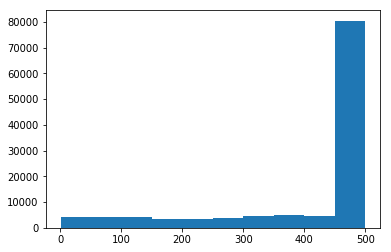

bike_by_workout 97562


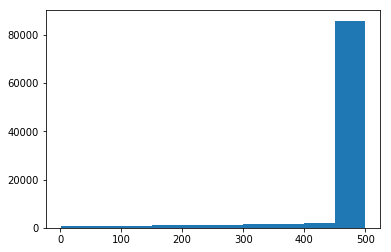

mountain_bike_by_workout 13491


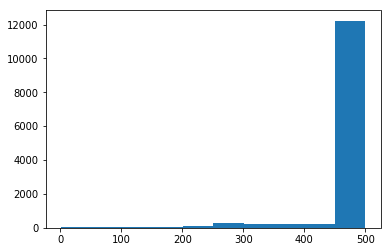

bike_transport_by_workout 10347


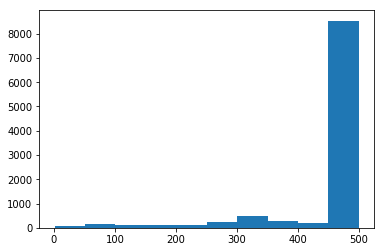

walk_by_workout 3787


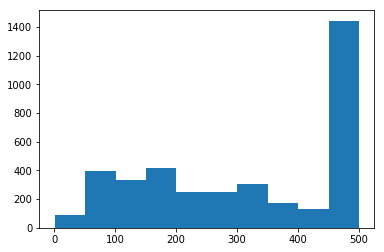

indoor_cycling_by_workout 2600


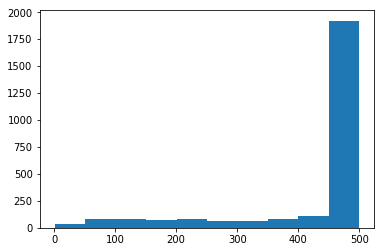

core_stability_training_by_workout 1250


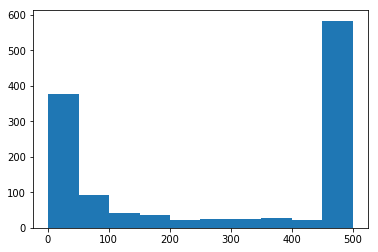

orienteering_by_workout 1197


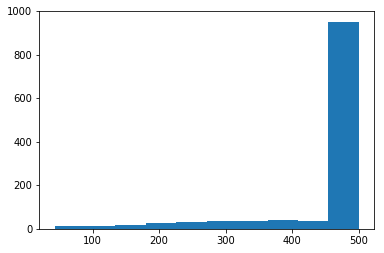

cross_country_skiing_by_workout 948


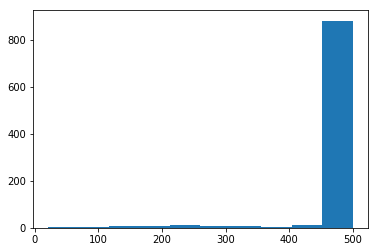

skate_by_workout 501


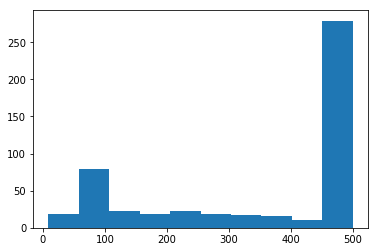

roller_skiing_by_workout 408


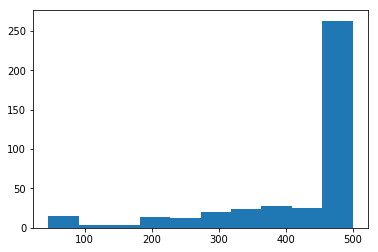

fitness_walking_by_workout 402


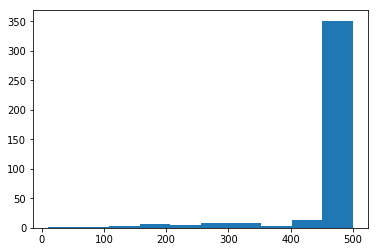

hiking_by_workout 356


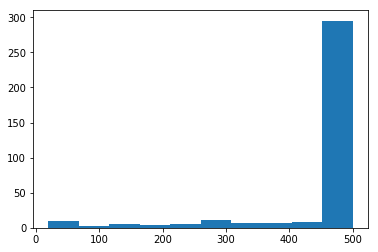

kayaking_by_workout 255


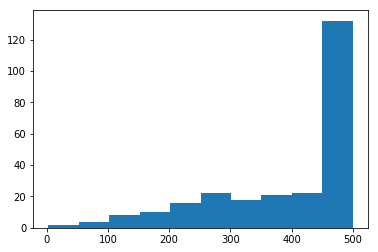

weight_training_by_workout 237


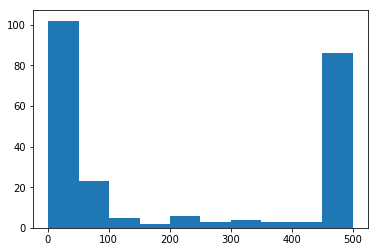

circuit_training_by_workout 218


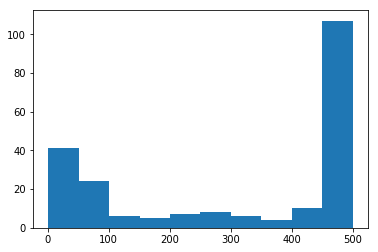

gymnastics_by_workout 162


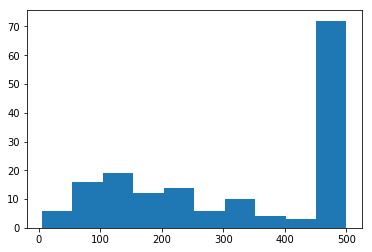

downhill_skiing_by_workout 138


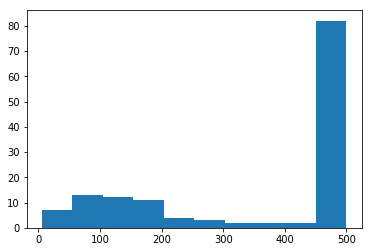

rowing_by_workout 127


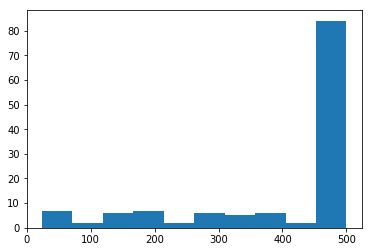

elliptical_by_workout 83


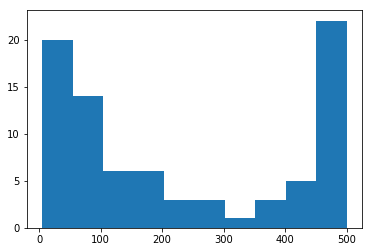

soccer_by_workout 71


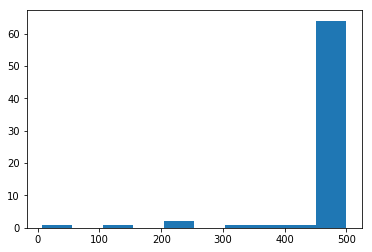

treadmill_running_by_workout 70


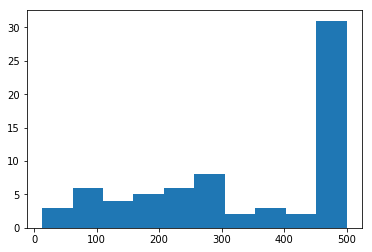

aerobics_by_workout 46


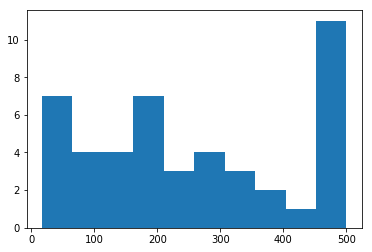

swimming_by_workout 41


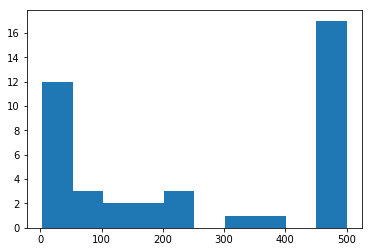

snowshoeing_by_workout 32


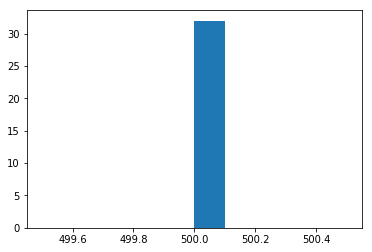

yoga_by_workout 22


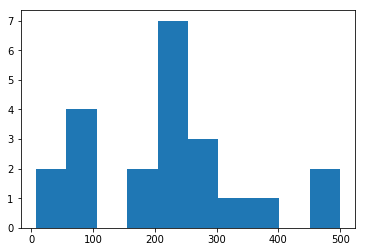

badminton_by_workout 17


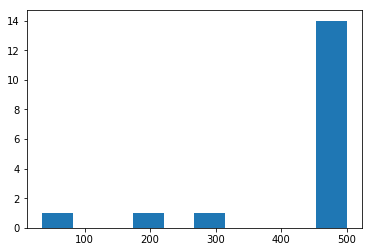

horseback_riding_by_workout 16


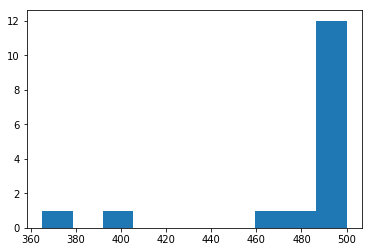

basketball_by_workout 14


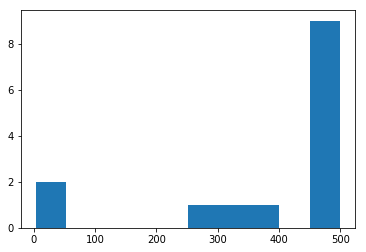

stair_climing_by_workout 13


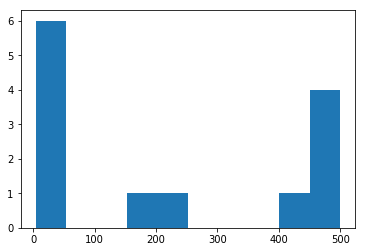

golf_by_workout 12


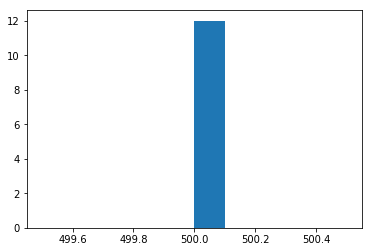

tennis_by_workout 8


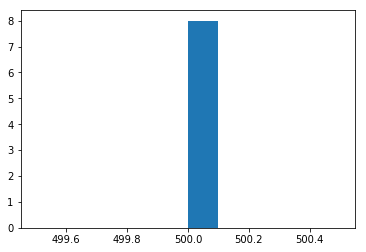

pilates_by_workout 7


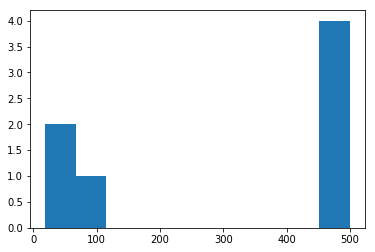

rugby_by_workout 7


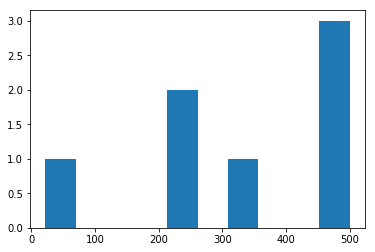

climbing_by_workout 6


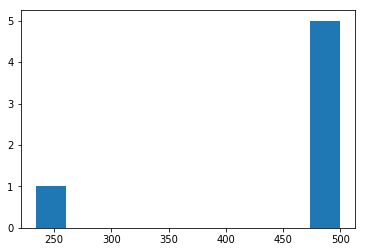

martial_arts_by_workout 5


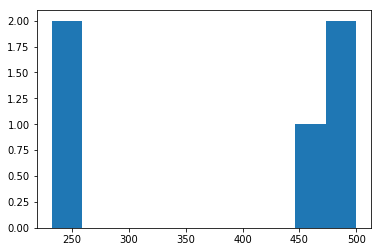

snowboarding_by_workout 5


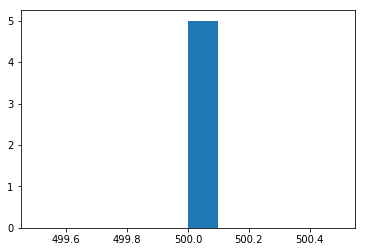

table_tennis_by_workout 5


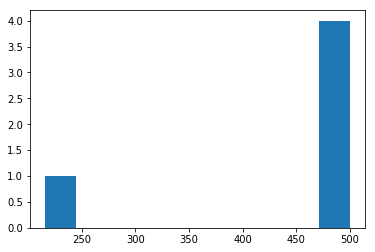

beach_volleyball_by_workout 2


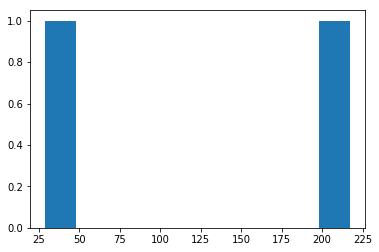

sailing_by_workout 2


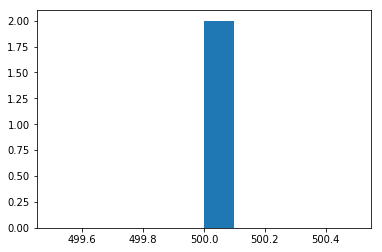

step_counter_by_workout 2


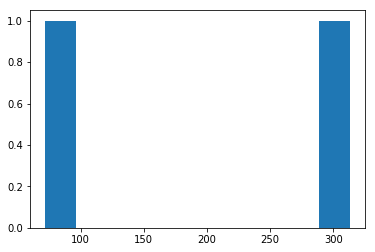

treadmill_walking_by_workout 2


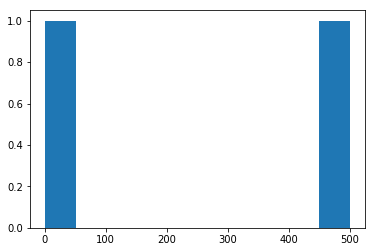

dancing_by_workout 1


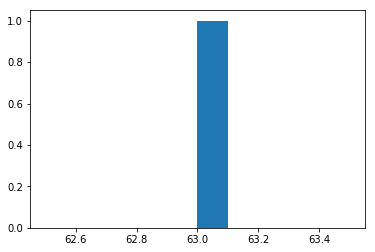

kite_surfing_by_workout 1


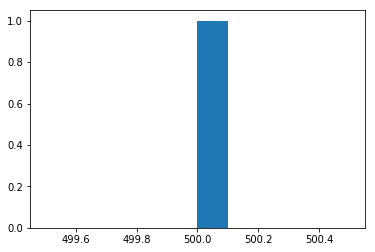

scuba_diving_by_workout 1


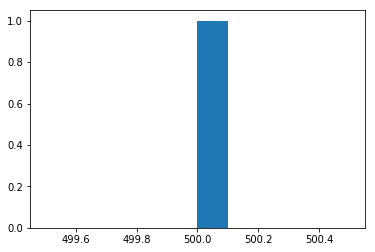

skateboarding_by_workout 1


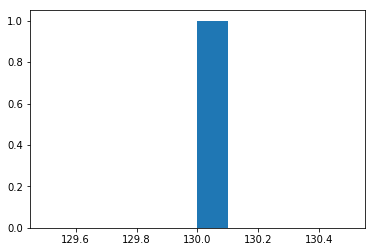

squash_by_workout 1


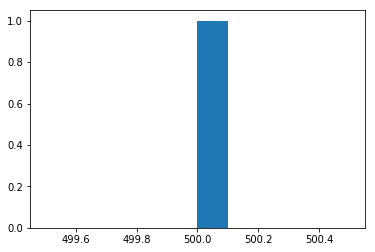

wheelchair_by_workout 1


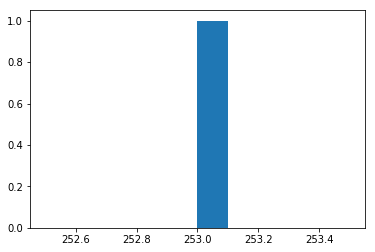

windsurfing_by_workout 1


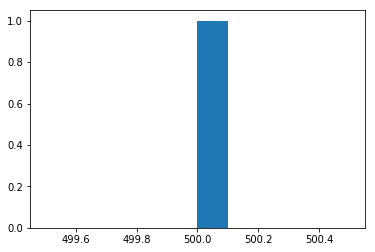

time: 9.32 s


In [107]:
for _workout in workout:
    print _workout[0], len(_workout[1])
    plt.hist(_workout[1])
    plt.show()